In [1]:
# %%
import os
import numpy as np
import torch
import h5py
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from tqdm import tqdm

notebook_path = os.getcwd()

# Construct the path to the directory containing 'fit'
parent_path = os.path.join(notebook_path, '..')
import sys
# Add this parent directory to the system path
sys.path.insert(0, parent_path)
data_dir = "/beegfs/desy/user/kaechben/calochallenge/"


In [2]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler

from utils.preprocess import ScalerBase, LogitTransformer,DQLinear, DQ

def shower_to_pc(args):
    shower, E = args
    shower, E = shower.clone(), E.clone()
    shower = shower.reshape(num_z, num_alpha, num_r).to_sparse()
    shower=shower.to_sparse()
    pc=torch.cat((shower.values().reshape(-1,1),shower.indices().T.float()),1)

    return {
        "Egen": torch.tensor(E).squeeze().clone(),
        "E_z_alpha_r": pc.clone(),
    }


In [3]:
big={"train": ["dataset_3_1.hdf5","dataset_3_2.hdf5"], "test": ["dataset_3_1.hdf5"]}
middle={"train": ["dataset_2_1.hdf5"], "test": ["dataset_2_2.hdf5"]}
outL=[]


outD={}
i=0
middle_dataset=False
name="middle" if middle_dataset else "big"
if middle_dataset:
    num_z = 45
    num_alpha = 16
    num_r = 9
    files=middle
else:
    num_z = 45
    num_alpha = 50
    num_r = 18
    files=big
with torch.no_grad():
    for mode in ["train"]:
        data_dir = "/beegfs/desy/user/kaechben/calochallenge/"
        for file in files[mode]:
            electron_file = h5py.File(data_dir + file, "r")
            energies = electron_file["incident_energies"][:10000]
            showers = electron_file["showers"][:100000]
            tempL = [shower_to_pc(e) for e in tqdm(zip(torch.tensor(showers), torch.tensor(energies)))]


            outL.extend(tempL)

        outD = {k: [e[k] for e in tempL] for k in outL[0].keys()}
        len_dict = [ len(x) for x in outD["E_z_alpha_r"]]

        if mode == "train": #only the train data is used to fit the scaler, and only the train data is transformed, the val data is not scaled
            scalar = ScalerBase(
                transfs=[
                    PowerTransformer(method="box-cox", standardize=True),
                    Pipeline([('dequantization', DQ()),('minmax_scaler', MinMaxScaler(feature_range=(1e-5, 1-1e-5))),('logit_transformer', LogitTransformer()),("standard_scaler",StandardScaler())])],

                featurenames=["E", "z", "alpha", "r"],
                name=name,
                overwrite=False,
            )
            arr = torch.vstack(outD["E_z_alpha_r"])
            arr,arr_inv=scalar.save_scalar(arr,save=False)
            arr=torch.from_numpy(arr).float()
            print("done")
            pc_list=[]
            i=0
            for l in len_dict:
                pc_list.append(arr[i:i+l].float())
                i+=l
            outD["E_z_alpha_r"]=pc_list
    #    torch.save(outD, f"{data_dir}pc_{mode}_{name}.pt")

In [13]:
responses=[]
for p,e in zip(pc_list,energies):
    if len(p)==0:
        continue
    p=scalar.inverse_transform(p)
    responses.append(p[:,0].sum()/e)
plt.hist(torch.cat(responses).numpy(),bins=100)
plt.savefig("test.png")

In [26]:
plt.close()
response= [x[:,0].numpy().sum()/ y for x,y in zip(outD["E_z_alpha_r"],outD["Egen"])]
plt.hist(response, bins=30,)

plt.savefig("test_response.png")

In [ ]:
outD = {k: [e[k] for e in tempL] for k in outL[0].keys()}
len_dict = [ len(x) for x in outD["E_z_alpha_r"]]


100

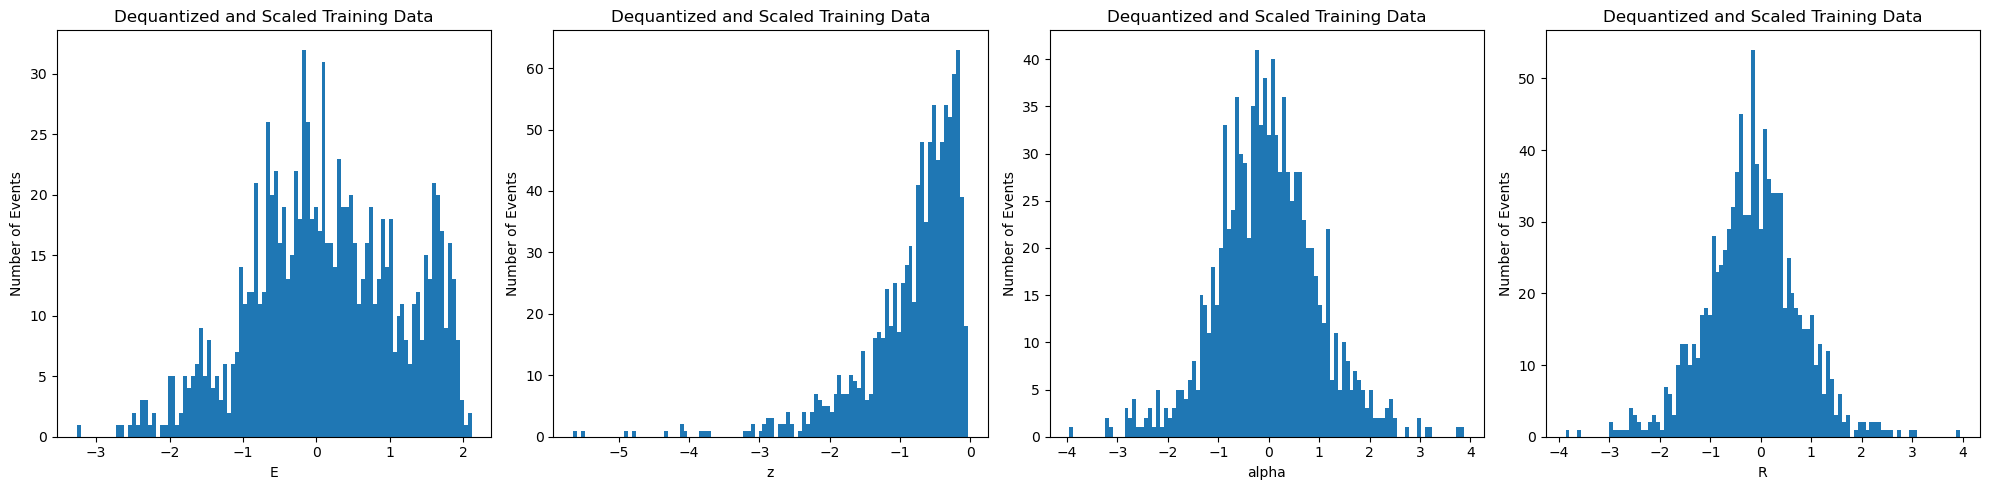

In [ ]:
X=scalar.transform(pcs=arr[:100000])
fig,ax=plt.subplots(1,4,figsize=(20,5))
bins=[100,10*num_z,10*num_alpha,10*num_r]
for i,col in enumerate(["E","z","alpha","R"]):
    ax[i].hist(X[:,i],bins=100)
    ax[i].set_title("Dequantized and Scaled Training Data")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Number of Events")
plt.tight_layout()
plt.show()
fig,ax=plt.subplots(1,4,figsize=(20,5))
for i,col in enumerate(["E","z","alpha","R"]):
    ax[i].hist(scalar.inverse_transform(torch.tensor(X).float())[:,i],bins=bins[i])
    ax[i].set_title("Requantized and Rescaled Training Data")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Number of Events")
plt.tight_layout()
plt.show()



In [2]:
train=torch.load("/beegfs/desy/user/kaechben/calochallenge/pc_train_big.pt")
train=train["E_z_alpha_r"]
plot_train=torch.cat([t.reshape(-1,4) for t in train])

scaler_big.gz
Scaler loaded


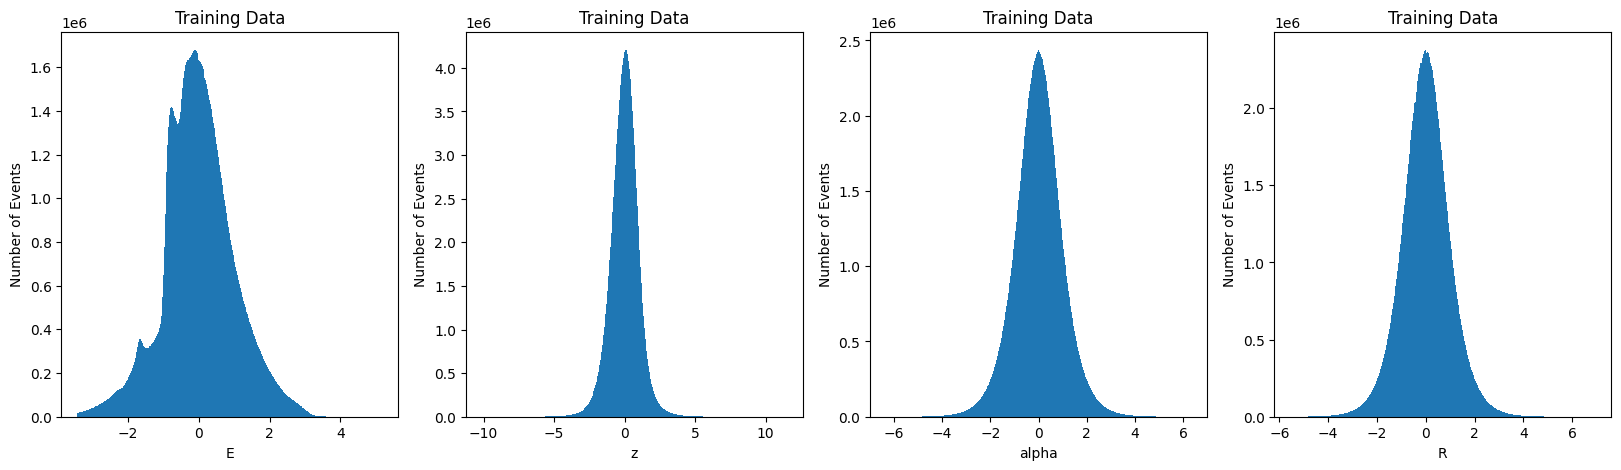

In [10]:
from utils.preprocess import ScalerBase, LogitTransformer,DQLinear, DQ
from sklearn.pipeline import Pipeline
scalar = ScalerBase(
                transfs=[
                    PowerTransformer(method="box-cox", standardize=True),
                    Pipeline([('dequantization', DQ()),('minmax_scaler', MinMaxScaler(feature_range=(1e-5, 1-1e-5))),('logit_transformer', LogitTransformer()),("standard_scaler",StandardScaler())])],

                featurenames=["E", "z", "alpha", "r"],
                name="big",
                overwrite=False,
            )
plot_train_=scalar.inverse_transform(plot_train)
fig,ax=plt.subplots(1,4,figsize=(20,5))
for i,col in enumerate(["E","z","alpha","R"]):
    ax[i].hist(plot_train.numpy()[:,i],bins=1000)
    ax[i].set_title("Training Data")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Number of Events")

In [12]:
data_dir = "/beegfs/desy/user/kaechben/calochallenge/"
file = "dataset_2_2.hdf5"
electron_file = h5py.File(data_dir + file, "r")
num_z=45
num_alpha=16
num_r=9
energies = electron_file["incident_energies"][:100000]
showers = electron_file["showers"][:100000]
tempL = [shower_to_pc(e)["E_z_alpha_r"].reshape(-1,4) for e in tqdm(zip(torch.tensor(showers), torch.tensor(energies)))]

/tmp/ipykernel_150873/3184197092.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "Egen": torch.tensor(E).squeeze().clone(),
100000it [00:34, 2930.45it/s]


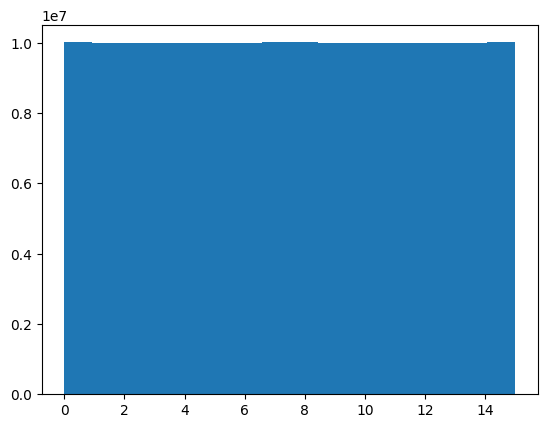

In [14]:
%matplotlib inline
plot_data=torch.cat([x.reshape(-1,4) for x in tempL]).numpy()
bins=np.linspace(0,50,50)
plot_data+=1e-5
plot_data=torch.clamp(torch.from_numpy(plot_data),0,48.999).numpy()
plt.hist(plot_data[:,2],bins=16)
plt.show()

In [3]:
def shower_to_pc(args):
    shower, E = args
    shower, E = shower.clone(), E.clone()
    shower = shower.reshape(num_z, num_alpha, num_r).to_sparse()
    shower=shower.to_sparse()
    pc=torch.cat((shower.values().reshape(-1,1),shower.indices().T.float()),1)

    return {
        "Egen": torch.tensor(E).squeeze().clone(),
        "E_z_alpha_r": pc.clone(),
    }
middle_dataset=False
if middle_dataset:
    num_z = 45
    num_alpha = 16
    num_r = 9
    files=middle
else:
    num_z = 45
    num_alpha = 50
    num_r = 18
outL=[]
with torch.no_grad():
    for mode in ["train"]:
        data_dir = "/beegfs/desy/user/kaechben/calochallenge/dataset_3_3.hdf5"

        electron_file = h5py.File(data_dir , "r")
        energies = electron_file["incident_energies"][:100000]
        showers = electron_file["showers"][:100000]
        tempL = [shower_to_pc(e) for e in tqdm(zip(torch.tensor(showers), torch.tensor(energies)))]


        outL.extend(tempL)

        outD = {k: [e[k] for e in tempL] for k in outL[0].keys()}
        len_dict = [ len(x) for x in outD["E_z_alpha_r"]]

0it [00:00, ?it/s]/tmp/ipykernel_162634/3902405730.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "Egen": torch.tensor(E).squeeze().clone(),
14607it [00:07, 1860.04it/s]

KeyboardInterrupt: 

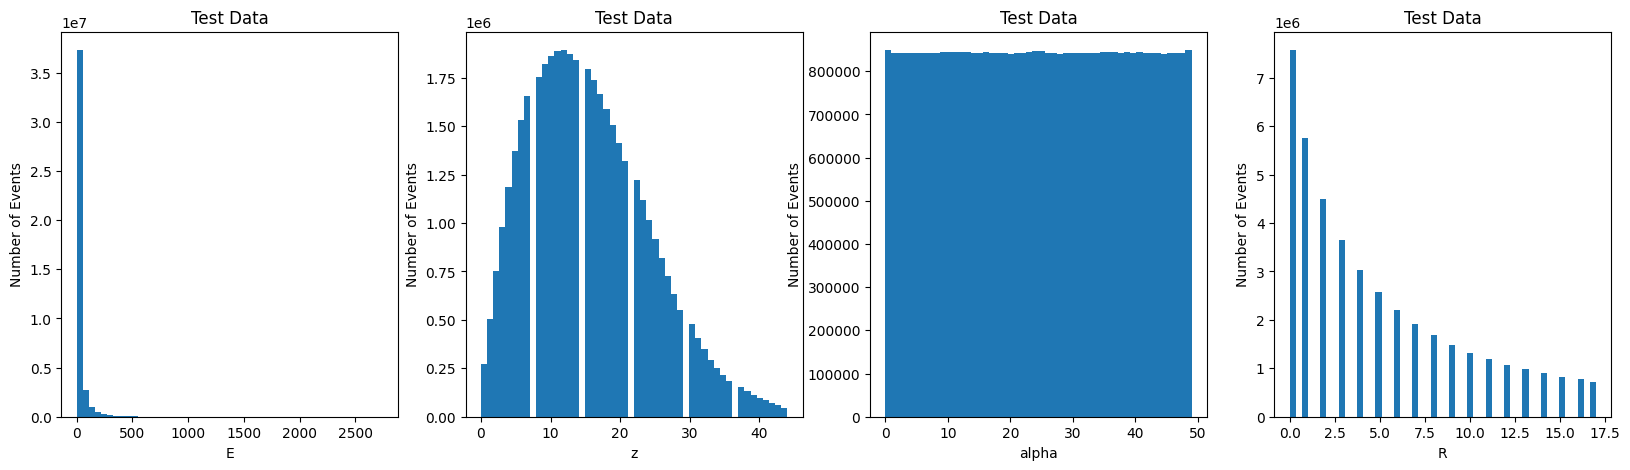

In [29]:
plot=[l.reshape(-1,4) for l in outD["E_z_alpha_r"]]
plot=torch.cat(plot)
fig,ax=plt.subplots(1,4,figsize=(20,5))
for i,col in enumerate(["E","z","alpha","R"]):
    ax[i].hist(plot.numpy()[:,i],bins=50)
    ax[i].set_title("Test Data")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Number of Events")


In [3]:
from utils.dataloader_calo import PointCloudDataloader
from utils.preprocess import ScalerBase, LogitTransformer,DQLinear, DQ
dm=PointCloudDataloader("big",1024,max=False,middle=True,scaler_path="/home/kaechben/MDMACalo/")
dm.setup("train")
responses=[]


100000
/home/kaechben/MDMACalo/scaler_middle.gz
Scaler loaded


In [4]:
responses=[]
xs,masks,conds=[],[],[]
# xs=torch.load("/beegfs/desy/user/kaechben/calochallenge/pc_train_middle.pt")
# xs.keys()
for i in dm.train_dataloader():
    x,mask,cond=i
    x=dm.scaler.inverse_transform(x)
    x[mask]=0
    xs.append(x)
    masks.append(mask)
    conds.append((cond+10).exp())
    responses.append(x[:,:,0].sum(1)/(cond[:,0,0]+10).exp())


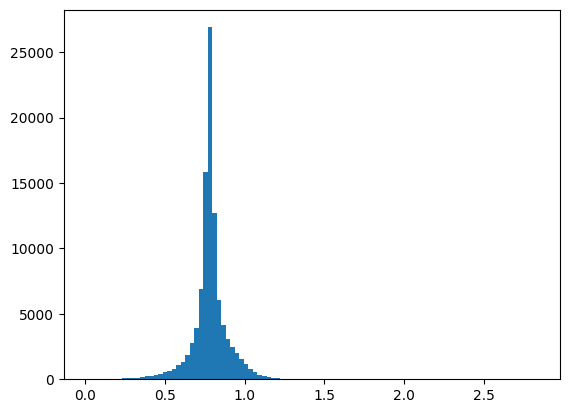

In [5]:
%matplotlib inline
plt.close()
plt.hist(torch.cat(responses).numpy(),bins=100)
# plt.yscale("log")
plt.show()



In [5]:
len(dm.train_dataloader())

TypeError: object of type 'BatchIterator' has no len()

In [79]:
pcs=[]
conds=[]
for x in xs["E_z_alpha_r"]:
    pcs.append(dm.scaler.inverse_transform(x))
for c in xs["Egen"]:
    conds.append(c)


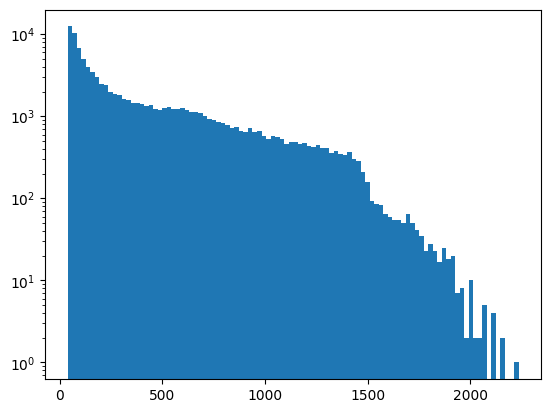

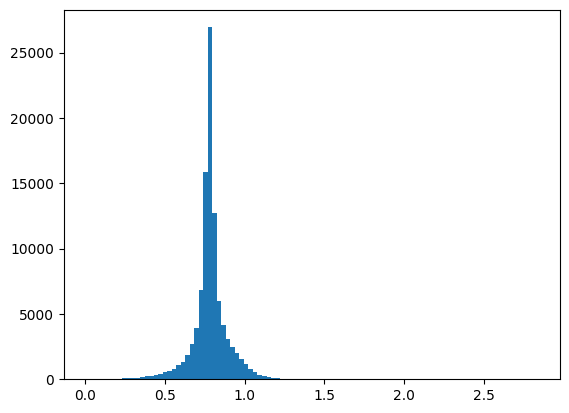

In [89]:
response=torch.tensor([pc[:,0].sum() for pc in pcs])/torch.tensor(conds).numpy()
plt.hist(response,bins=100)
plt.show()

tensor([118329.5781, 693566.8125,   3762.9700,  ..., 688751.9375,
        145378.1875,   6909.7441])

In [67]:
sum([len(x) for x in xs])

100000

(array([5.410e+02, 4.734e+03, 8.126e+03, 5.611e+03, 4.395e+03, 3.695e+03,
        3.233e+03, 2.922e+03, 2.490e+03, 2.343e+03, 2.126e+03, 1.864e+03,
        1.731e+03, 1.639e+03, 1.584e+03, 1.476e+03, 1.353e+03, 1.302e+03,
        1.224e+03, 1.204e+03, 1.122e+03, 1.087e+03, 1.104e+03, 1.084e+03,
        9.840e+02, 9.830e+02, 8.950e+02, 9.190e+02, 8.740e+02, 8.030e+02,
        8.050e+02, 7.630e+02, 7.880e+02, 8.010e+02, 7.470e+02, 7.170e+02,
        6.920e+02, 6.850e+02, 7.430e+02, 6.910e+02, 6.340e+02, 6.780e+02,
        6.220e+02, 6.930e+02, 6.100e+02, 6.130e+02, 6.160e+02, 6.200e+02,
        5.910e+02, 6.130e+02, 5.770e+02, 5.910e+02, 5.770e+02, 5.780e+02,
        5.880e+02, 5.720e+02, 5.410e+02, 6.060e+02, 5.720e+02, 5.290e+02,
        5.560e+02, 5.630e+02, 5.380e+02, 5.720e+02, 5.180e+02, 5.360e+02,
        5.550e+02, 5.320e+02, 5.500e+02, 5.300e+02, 5.270e+02, 5.630e+02,
        5.290e+02, 5.600e+02, 5.090e+02, 5.890e+02, 5.380e+02, 5.440e+02,
        5.540e+02, 5.510e+02, 5.240e+0

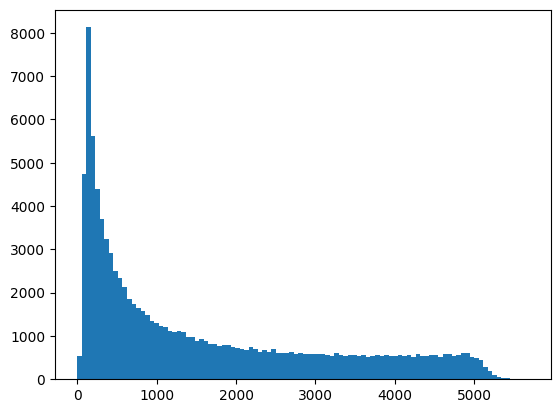

In [59]:
n=torch.cat([ (~mask).int().sum(1) for mask in masks])
plt.hist(n.numpy(),bins=100)
